In [1]:
from __future__ import print_function, division
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from data_preprocess import get_data_loader, CustomDataset
%load_ext autoreload
%autoreload 2

In [2]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

data_dir = "/scratch/jt3149/"#folder of data
snapshots_dir = '/scratch/jt3149/snapshots/'#folder to save snapshots
train_loader, val_loader, test_loader = get_data_loader(data_dir, batch_size=1, trans=preprocess, val_size = 0.2)

In [3]:
positive_images = []
negative_images = []
for img, lab in train_loader:
    if lab == 1:
        if len(positive_images) < 4:
            positive_images.append(img)
    else:
        if len(negative_images) < 4:
            negative_images.append(img)
    if len(positive_images) + len(negative_images) == 8:
        break

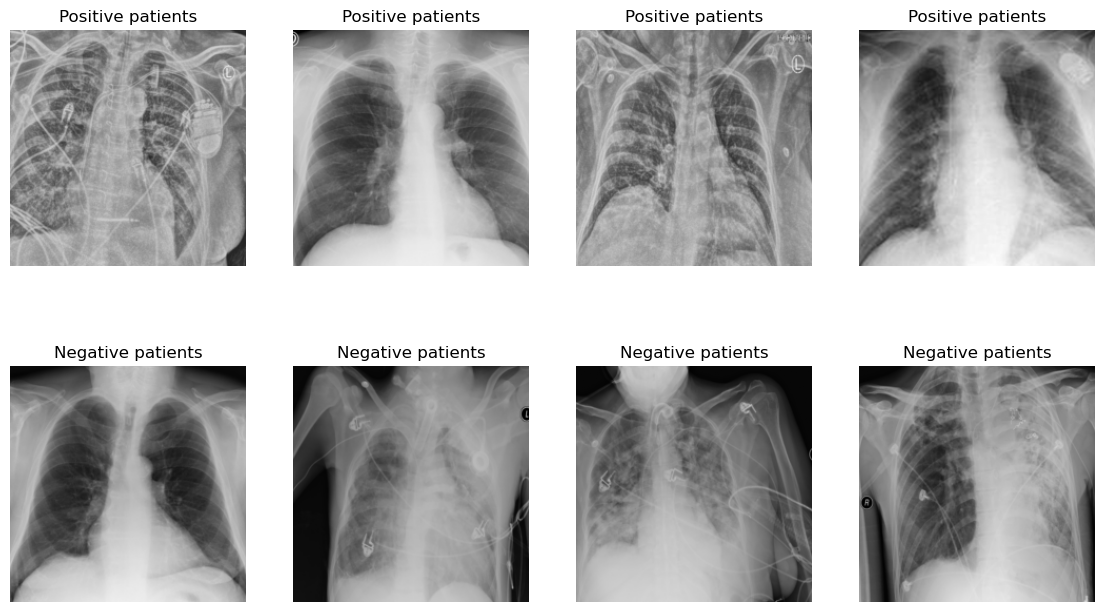

In [4]:
fig, ax = plt.subplots(2,4,figsize=(14,8))
for i,img in enumerate(positive_images):
    ax[0][i].imshow(img[0].numpy().transpose((1, 2, 0)))
    ax[0][i].set_title('Positive patients')
    ax[0][i].axis('off')
for i,img in enumerate(negative_images):
    ax[1][i].imshow(img[0].numpy().transpose((1, 2, 0)))
    ax[1][i].set_title('Negative patients')
    ax[1][i].axis('off')            

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [19]:
# read the pretrained densenet
densenet_based = torchvision.models.densenet201(weights='DenseNet201_Weights.DEFAULT')

## freeze the layers
for param in densenet_based.parameters():
    param.requires_grad = False
    
# print(densenet_based)

In [20]:
# Modify the last layer
number_features = densenet_based.classifier.in_features

features = list(densenet_based.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(number_features, 256), 
                 nn.ReLU(),
                 nn.Dropout(0.5), 
                 nn.Linear(256, 256), 
                 nn.ReLU(), 
                 nn.Linear(256, 1) 
                 ])
densenet_based.classifier = nn.Sequential(*features)

densenet_based = densenet_based.to(device)

In [25]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, snapshot_interval, epochs, snapshots_dir):
    train_loss_list, val_loss_list = np.zeros(epochs), np.zeros(epochs)
    for epoch in range(epochs):
        since = time.time()
        train_loss,val_loss = 0,0
        #train one epoch
        print(f'Epoch {epoch + 1}/{epochs}, learning rate: {scheduler.get_lr()[0]:.5f}')
        # Iterate over data.
        model.train()
        for i, (inputs, labels) in tqdm(enumerate(train_loader)):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs  = model(inputs)
                loss = criterion(outputs, labels.float().view(-1,1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss_list[epoch] = train_loss
        print(f'Train Loss: {train_loss / len(train_loader):.2f}')
        # test on validation loader
        if (epoch+1) % 5 ==0:
            model.eval()
            for i, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                loss = criterion(model(inputs), labels.float().view(-1,1))
                val_loss += loss.item()
            val_loss_list[epoch] = val_loss
            print(f'Val loss: {val_loss / len(val_loader):.2f}')
                  
        scheduler.step()        
        time_elapsed = time.time() - since
        print(f'Time taken: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
        print('-' * 10)
        if (epoch + 1) % snapshot_interval == 0:
            #save a snapshot
            snapshot_name = f'snapshot{(epoch + 1) / snapshot_interval}.pt'
#             torch.save(model.state_dict(), snapshots_dir+snapshot_name)
            torch.save({
                    'name':snapshot_name,
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    }, snapshots_dir+snapshot_name)
            print(f'The {(epoch + 1) / snapshot_interval} time resetting scheduler')
    return model, train_loss_list, val_loss_list

In [26]:
model = densenet_based
train_loader = train_loader
val_loader = val_loader
criterion = torch.nn.BCEWithLogitsLoss()
# COSINE ANNEALING WARM RESTARTS
optimizer = optim.SGD(densenet_based.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 10, T_mult=1, eta_min=0, last_epoch= -1, verbose=False)
# save a snapshot every 10 epochs, save 5 snapshots
snapshot_interval, epochs = 10, 50


results = train_model(model.to(device), train_loader, val_loader, criterion, optimizer, scheduler, snapshot_interval, epochs, snapshots_dir)

Epoch 1/50, learning rate: 0.01000


94it [00:23,  5.83it/s]

25% training done


188it [00:48,  4.32it/s]

50% training done


282it [01:09,  3.30it/s]

75% training done


375it [01:29,  4.17it/s]

Train Loss: 0.49
Time taken: 1m 31s
----------
Epoch 2/50, learning rate: 0.00976



94it [00:14,  7.17it/s]

25% training done


188it [00:27,  7.10it/s]

50% training done


282it [00:41,  6.19it/s]

75% training done


375it [00:56,  6.69it/s]

Train Loss: 0.26
Time taken: 0m 57s
----------
Epoch 3/50, learning rate: 0.00905



94it [00:14,  7.31it/s]

25% training done


188it [00:26,  8.26it/s]

50% training done


282it [00:38,  7.88it/s]

75% training done


375it [00:51,  7.35it/s]

Train Loss: 0.22
Time taken: 0m 52s
----------
Epoch 4/50, learning rate: 0.00794



94it [00:14,  8.31it/s]

25% training done


188it [00:27,  8.27it/s]

50% training done


282it [00:39,  8.33it/s]

75% training done


375it [00:51,  7.27it/s]


Train Loss: 0.19
Time taken: 0m 52s
----------
Epoch 5/50, learning rate: 0.00655


94it [00:14,  7.35it/s]

25% training done


188it [00:33,  8.24it/s]

50% training done


282it [00:46,  5.68it/s]

75% training done


375it [00:59,  6.32it/s]

Train Loss: 0.18


Val loss: 0.14
Time taken: 1m 25s
----------
Epoch 6/50, learning rate: 0.00500


94it [00:14,  8.26it/s]

25% training done


188it [00:28,  8.28it/s]

50% training done


282it [00:41,  6.72it/s]

75% training done


375it [00:55,  6.76it/s]

Train Loss: 0.17
Time taken: 0m 56s
----------
Epoch 7/50, learning rate: 0.00345



94it [00:12,  7.43it/s]

25% training done


188it [00:24,  8.29it/s]

50% training done


282it [00:37,  8.19it/s]

75% training done


375it [00:49,  7.51it/s]

Train Loss: 0.17
Time taken: 0m 50s
----------
Epoch 8/50, learning rate: 0.00206



94it [00:12,  8.28it/s]

25% training done


188it [00:25,  8.28it/s]

50% training done


282it [00:37,  7.70it/s]

75% training done


375it [00:50,  7.42it/s]

Train Loss: 0.16
Time taken: 0m 51s
----------
Epoch 9/50, learning rate: 0.00095



94it [00:13,  8.27it/s]

25% training done


188it [00:25,  8.24it/s]

50% training done


282it [00:37,  8.29it/s]

75% training done


375it [00:50,  7.47it/s]

Train Loss: 0.16
Time taken: 0m 51s
----------
Epoch 10/50, learning rate: 0.00024



94it [00:13,  8.27it/s]

25% training done


188it [00:25,  5.65it/s]

50% training done


282it [00:38,  8.30it/s]

75% training done


375it [00:51,  7.25it/s]

Train Loss: 0.16


Val loss: 0.13
Time taken: 1m 7s
----------
The 1.0 time resetting scheduler
Epoch 11/50, learning rate: 0.01000


94it [00:13,  8.29it/s]

25% training done


188it [00:25,  6.37it/s]

50% training done


282it [00:39,  8.25it/s]

75% training done


375it [00:51,  7.24it/s]

Train Loss: 0.16
Time taken: 0m 52s
----------
Epoch 12/50, learning rate: 0.00976



94it [00:13,  7.23it/s]

25% training done


188it [00:26,  6.49it/s]

50% training done


282it [00:38,  8.27it/s]

75% training done


375it [00:52,  7.21it/s]

Train Loss: 0.16
Time taken: 0m 53s
----------
Epoch 13/50, learning rate: 0.00905



94it [00:13,  8.24it/s]

25% training done


188it [00:26,  8.01it/s]

50% training done


282it [00:38,  8.27it/s]

75% training done


375it [00:51,  7.30it/s]


Train Loss: 0.15
Time taken: 0m 52s
----------
Epoch 14/50, learning rate: 0.00794


94it [00:13,  8.26it/s]

25% training done


188it [00:26,  5.76it/s]

50% training done


282it [00:39,  8.27it/s]

75% training done


375it [00:51,  7.22it/s]

Train Loss: 0.15
Time taken: 0m 53s
----------
Epoch 15/50, learning rate: 0.00655



94it [00:13,  8.06it/s]

25% training done


188it [00:25,  8.19it/s]

50% training done


282it [00:37,  8.30it/s]

75% training done


375it [00:49,  7.51it/s]

Train Loss: 0.14


Val loss: 0.12
Time taken: 1m 5s
----------
Epoch 16/50, learning rate: 0.00500


94it [00:13,  8.32it/s]

25% training done


188it [00:26,  8.28it/s]

50% training done


282it [00:38,  8.22it/s]

75% training done


375it [00:50,  7.39it/s]

Train Loss: 0.14
Time taken: 0m 51s
----------
Epoch 17/50, learning rate: 0.00345



94it [00:13,  7.86it/s]

25% training done


188it [00:26,  6.78it/s]

50% training done


282it [00:39,  6.64it/s]

75% training done


375it [00:51,  7.22it/s]

Train Loss: 0.13
Time taken: 0m 53s
----------
Epoch 18/50, learning rate: 0.00206



94it [00:12,  8.04it/s]

25% training done


188it [00:26,  8.31it/s]

50% training done


282it [00:40,  8.30it/s]

75% training done


375it [00:53,  7.07it/s]

Train Loss: 0.14
Time taken: 0m 54s
----------
Epoch 19/50, learning rate: 0.00095



94it [00:13,  8.32it/s]

25% training done


188it [00:26,  6.76it/s]

50% training done


282it [00:39,  8.12it/s]

75% training done


375it [00:51,  7.24it/s]

Train Loss: 0.13
Time taken: 0m 52s
----------
Epoch 20/50, learning rate: 0.00024



94it [00:14,  8.31it/s]

25% training done


188it [00:27,  7.25it/s]

50% training done


282it [00:40,  6.68it/s]

75% training done


375it [00:53,  7.05it/s]

Train Loss: 0.13


Val loss: 0.12
Time taken: 1m 10s
----------
The 2.0 time resetting scheduler
Epoch 21/50, learning rate: 0.01000


94it [00:13,  8.23it/s]

25% training done


188it [00:25,  8.12it/s]

50% training done


282it [00:39,  4.66it/s]

75% training done


375it [00:52,  7.14it/s]

Train Loss: 0.13
Time taken: 0m 53s
----------
Epoch 22/50, learning rate: 0.00976



94it [00:13,  7.56it/s]

25% training done


188it [00:26,  8.26it/s]

50% training done


282it [00:38,  8.28it/s]

75% training done


375it [00:50,  7.38it/s]


Train Loss: 0.13
Time taken: 0m 51s
----------
Epoch 23/50, learning rate: 0.00905


94it [00:13,  8.29it/s]

25% training done


188it [00:25,  8.27it/s]

50% training done


282it [00:38,  8.09it/s]

75% training done


375it [00:52,  7.18it/s]

Train Loss: 0.13
Time taken: 0m 53s
----------
Epoch 24/50, learning rate: 0.00794



94it [00:13,  6.48it/s]

25% training done


188it [00:26,  8.31it/s]

50% training done


282it [00:38,  8.22it/s]

75% training done


375it [00:53,  7.06it/s]

Train Loss: 0.12
Time taken: 0m 54s
----------
Epoch 25/50, learning rate: 0.00655



94it [00:13,  8.32it/s]

25% training done


188it [00:25,  8.28it/s]

50% training done


282it [00:39,  5.77it/s]

75% training done


375it [00:51,  7.21it/s]

Train Loss: 0.12


Val loss: 0.14
Time taken: 1m 7s
----------
Epoch 26/50, learning rate: 0.00500


94it [00:14,  6.25it/s]

25% training done


188it [00:26,  7.95it/s]

50% training done


282it [00:39,  8.28it/s]

75% training done


375it [00:52,  7.16it/s]

Train Loss: 0.11
Time taken: 0m 53s
----------
Epoch 27/50, learning rate: 0.00345



94it [00:13,  7.67it/s]

25% training done


188it [00:25,  6.96it/s]

50% training done


282it [00:38,  4.95it/s]

75% training done


375it [00:50,  7.40it/s]

Train Loss: 0.11
Time taken: 0m 51s
----------
Epoch 28/50, learning rate: 0.00206



94it [00:13,  8.24it/s]

25% training done


188it [00:26,  8.24it/s]

50% training done


282it [00:38,  5.11it/s]

75% training done


375it [00:50,  7.37it/s]

Train Loss: 0.11
Time taken: 0m 51s
----------
Epoch 29/50, learning rate: 0.00095



94it [00:14,  8.29it/s]

25% training done


188it [00:27,  7.52it/s]

50% training done


282it [00:39,  8.29it/s]

75% training done


375it [00:51,  7.25it/s]

Train Loss: 0.11
Time taken: 0m 52s
----------
Epoch 30/50, learning rate: 0.00024



94it [00:14,  8.24it/s]

25% training done


188it [00:26,  8.21it/s]

50% training done


282it [00:39,  8.34it/s]

75% training done


375it [00:51,  7.34it/s]


Train Loss: 0.11
Val loss: 0.11
Time taken: 1m 7s
----------
The 3.0 time resetting scheduler
Epoch 31/50, learning rate: 0.01000


94it [00:12,  8.27it/s]

25% training done


188it [00:25,  8.26it/s]

50% training done


282it [00:38,  8.28it/s]

75% training done


375it [00:50,  7.37it/s]

Train Loss: 0.12
Time taken: 0m 51s
----------
Epoch 32/50, learning rate: 0.00976



94it [00:13,  8.31it/s]

25% training done


188it [00:26,  8.24it/s]

50% training done


282it [00:38,  8.30it/s]

75% training done


375it [00:52,  7.18it/s]

Train Loss: 0.11
Time taken: 0m 53s
----------
Epoch 33/50, learning rate: 0.00905



94it [00:13,  7.52it/s]

25% training done


188it [00:25,  8.30it/s]

50% training done


282it [00:37,  8.27it/s]

75% training done


375it [00:50,  7.46it/s]

Train Loss: 0.11
Time taken: 0m 51s
----------
Epoch 34/50, learning rate: 0.00794



94it [00:13,  7.87it/s]

25% training done


188it [00:26,  7.86it/s]

50% training done


282it [00:38,  8.31it/s]

75% training done


375it [00:50,  7.38it/s]

Train Loss: 0.11
Time taken: 0m 51s
----------
Epoch 35/50, learning rate: 0.00655



94it [00:13,  8.23it/s]

25% training done


188it [00:26,  6.58it/s]

50% training done


282it [00:39,  8.16it/s]

75% training done


375it [00:50,  7.37it/s]

Train Loss: 0.10


Val loss: 0.11
Time taken: 1m 7s
----------
Epoch 36/50, learning rate: 0.00500


94it [00:14,  6.76it/s]

25% training done


188it [00:27,  8.10it/s]

50% training done


282it [00:39,  8.28it/s]

75% training done


375it [00:52,  7.12it/s]

Train Loss: 0.10
Time taken: 0m 53s
----------
Epoch 37/50, learning rate: 0.00345



94it [00:13,  8.26it/s]

25% training done


188it [00:25,  8.31it/s]

50% training done


282it [00:37,  8.26it/s]

75% training done


375it [00:49,  7.58it/s]

Train Loss: 0.09
Time taken: 0m 50s
----------
Epoch 38/50, learning rate: 0.00206



94it [00:13,  8.29it/s]

25% training done


188it [00:25,  8.29it/s]

50% training done


282it [00:37,  8.29it/s]

75% training done


375it [00:51,  7.22it/s]

Train Loss: 0.10
Time taken: 0m 53s
----------
Epoch 39/50, learning rate: 0.00095



94it [00:13,  7.92it/s]

25% training done


188it [00:25,  8.22it/s]

50% training done


282it [00:38,  7.96it/s]

75% training done


375it [00:51,  7.27it/s]

Train Loss: 0.09
Time taken: 0m 52s
----------
Epoch 40/50, learning rate: 0.00024



94it [00:13,  7.99it/s]

25% training done


188it [00:25,  6.30it/s]

50% training done


282it [00:37,  6.82it/s]

75% training done


375it [00:51,  7.35it/s]

Train Loss: 0.09


Val loss: 0.11
Time taken: 1m 7s
----------
The 4.0 time resetting scheduler
Epoch 41/50, learning rate: 0.01000


94it [00:13,  7.39it/s]

25% training done


188it [00:25,  8.31it/s]

50% training done


282it [00:37,  8.08it/s]

75% training done


375it [00:50,  7.40it/s]

Train Loss: 0.10
Time taken: 0m 51s
----------
Epoch 42/50, learning rate: 0.00976



94it [00:13,  7.90it/s]

25% training done


188it [00:25,  8.28it/s]

50% training done


282it [00:38,  7.54it/s]

75% training done


375it [00:51,  7.24it/s]


Train Loss: 0.10
Time taken: 0m 52s
----------
Epoch 43/50, learning rate: 0.00905


94it [00:14,  6.40it/s]

25% training done


188it [00:27,  7.41it/s]

50% training done


282it [00:40,  4.87it/s]

75% training done


375it [00:53,  7.05it/s]

Train Loss: 0.10
Time taken: 0m 54s
----------
Epoch 44/50, learning rate: 0.00794



94it [00:12,  7.00it/s]

25% training done


188it [00:24,  8.11it/s]

50% training done


282it [00:37,  7.21it/s]

75% training done


375it [00:51,  7.29it/s]

Train Loss: 0.09
Time taken: 0m 52s
----------
Epoch 45/50, learning rate: 0.00655



94it [00:13,  6.78it/s]

25% training done


188it [00:26,  7.94it/s]

50% training done


282it [00:38,  8.24it/s]

75% training done


375it [00:53,  6.95it/s]

Train Loss: 0.09


Val loss: 0.10
Time taken: 1m 14s
----------
Epoch 46/50, learning rate: 0.00500


94it [00:15,  8.21it/s]

25% training done


188it [00:27,  7.51it/s]

50% training done


282it [00:41,  7.21it/s]

75% training done


375it [00:53,  7.03it/s]

Train Loss: 0.09
Time taken: 0m 54s
----------
Epoch 47/50, learning rate: 0.00345



94it [00:12,  8.31it/s]

25% training done


188it [00:25,  8.27it/s]

50% training done


282it [00:38,  8.24it/s]

75% training done


375it [00:50,  7.39it/s]

Train Loss: 0.08
Time taken: 0m 51s
----------
Epoch 48/50, learning rate: 0.00206



94it [00:13,  8.24it/s]

25% training done


188it [00:25,  8.28it/s]

50% training done


282it [00:37,  6.99it/s]

75% training done


375it [00:51,  7.21it/s]

Train Loss: 0.08
Time taken: 0m 53s
----------
Epoch 49/50, learning rate: 0.00095



94it [00:13,  7.86it/s]

25% training done


188it [00:26,  8.33it/s]

50% training done


282it [00:39,  5.23it/s]

75% training done


375it [00:52,  7.10it/s]


Train Loss: 0.08
Time taken: 0m 53s
----------
Epoch 50/50, learning rate: 0.00024


94it [00:13,  6.41it/s]

25% training done


188it [00:25,  7.74it/s]

50% training done


282it [00:37,  7.53it/s]

75% training done


375it [00:50,  7.48it/s]

Train Loss: 0.08


Val loss: 0.10
Time taken: 1m 6s
----------
The 5.0 time resetting scheduler
